In [2]:
# import data
import pandas as pd
pheno = pd.read_csv('/home/hermuba/data0118/annotated_RIS/RIS_pivot_ecoli.csv', dtype = {'Genome ID': str})
# absense presence
pangenome = pd.read_csv('/home/hermuba/data0118/cdhit/clstr/pangenome_df/Escherichia0.70rm_plasmid.clstr.csv', index_col = 0)

# select E.coli phenotype data
pheno = pheno.loc[pheno['Genome ID'].isin(pangenome.columns)]
pheno.set_index('Genome ID', inplace = True)
pheno.shape # 39 drugs, 1580 genomes

# select drug with abundant data
drugs = pheno.count().sort_values()[-25:].index 

# read annotation file
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')

In [3]:
# cluster number --> gene IDx
cluster_no = gold_anno['cluster']
mapper_fun = pd.Series(cluster_no.index, index = cluster_no.values)

# transpose
pangenome = pangenome.transpose(copy = False)

# rename cluster by gene ID and then transform data type
can_pan = pangenome.rename(columns = mapper_fun)
can_pan = can_pan.astype('bool')

In [4]:
# finding significant genes within pangenome
def preprocessing(df, ris, abx):
    y= ris[abx].dropna()
    X = df.loc[y.index]
    # at least one genome having that gene gaurentee it to worth examine
    X = X.loc[:,X.sum()>0]
    # not core genes
    X = X.loc[:,X.sum() < X.shape[0]]
    return(X, y)

# perform fisher and FDR corretion
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
def test_all_drug_fisher(drugs, df, ris):
    corr_p_values = pd.DataFrame(index = df.columns, columns = drugs) # index = genes, column = drug, value = uncorrected p value
    significant = pd.DataFrame(index = df.columns, columns = drugs)
    odds_df = pd.DataFrame(index = df.columns, columns = drugs)
    for d in drugs:
        print(d)
        X, y = preprocessing(df, ris, d)
        odds_list = []
        uncorrected_pvalues = []
        for column in X.columns: 
            if pd.crosstab(X[column], y).shape != (2,2):
                print(d, column)
            c = pd.crosstab(X[column], y) # contingency
            if c.eq(0).any().any(): # if any 0 in contingency table
                c = c + 0.5 # perform Haldane-Anscombe correction
                
            odds, p = stats.fisher_exact(c) 
            odds = c.loc[False,0]*c.loc[True,1]/c.loc[False,1]/c.loc[True, 0] # weird that the original fisher returns uncorreted odds
            odds_list.append(odds)
            uncorrected_pvalues.append(p)
        rejected, p_corrected = fdrcorrection(uncorrected_pvalues, alpha=0.05)
        corr_p_values.loc[X.columns, d] = p_corrected
        significant.loc[X.columns, d] = rejected
        odds_df.loc[X.columns, d] = odds_list
    return(corr_p_values, significant, odds_df)

In [9]:
genotype_p_fisher, genotype_reject_fisher, genotype_odds = test_all_drug_fisher(['amoxicillin'], can_pan, pheno)

amoxicillin


/home/hermuba/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/hermuba/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


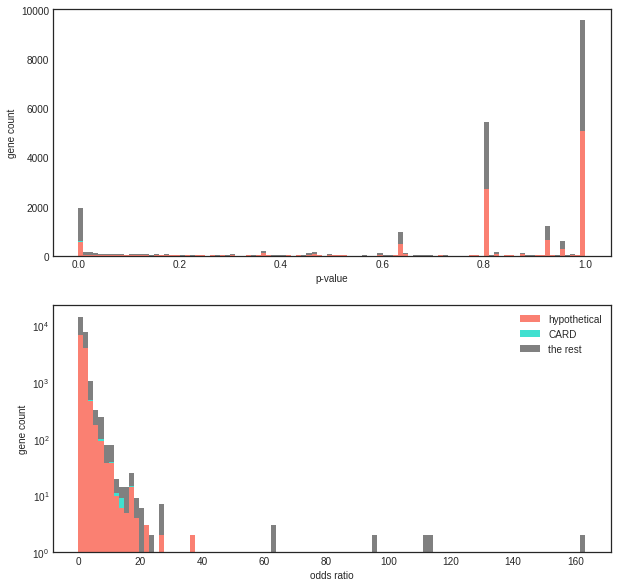

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-white')

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))
genotype_p_fisher = pd.read_csv("/home/hermuba/data0118/significant_amox.csv", header = 0, index_col = 0)
genotype_p_fisher['hypo_nr'] = gold_anno.loc[genotype_p_fisher.index[:-1], 'hypo_nr']
genotype_p_fisher['is_card'] = gold_anno.loc[genotype_p_fisher.index[:-1], 'is_card']

ax[0].hist([genotype_p_fisher.loc[genotype_p_fisher['hypo_nr'] == True, 'amoxicillin'],
         genotype_p_fisher.loc[genotype_p_fisher['is_card'] == True, 'amoxicillin'],
          genotype_p_fisher.loc[genotype_p_fisher['hypo_nr'].isnull(), 'amoxicillin']],
         bins=100, stacked=True, color = ['salmon','turquoise','grey'], label = ['hypothetical','CARD','the rest'])

ax[0].set_xlabel('p-value')
ax[0].set_ylabel('gene count')


genotype_odds = pd.read_csv("/home/hermuba/data0118/significant_amox_odds.csv", header = 0, index_col = 0)
ax[1].hist([genotype_odds.loc[genotype_odds['hypo_nr'] == True, 'amoxicillin'],
          genotype_odds.loc[genotype_odds['is_card'] == True, 'amoxicillin'],
          genotype_odds.loc[genotype_odds['hypo_nr'].isnull(), 'amoxicillin']],
         bins=100, stacked=True, color = ['salmon','turquoise','grey'], label = ['hypothetical','CARD','the rest'])

ax[1].set_xlabel('odds ratio')
ax[1].set_ylabel('gene count')
ax[1].set_yscale('log')

plt.legend()


plt.savefig('/home/hermuba/data0118/fig/fig_1_significant_genes.pdf', dpi = 300, format = 'pdf')



In [20]:
#genotype_p_fisher.to_csv("/home/hermuba/data0118/significant_amox.csv")

In [75]:
#genotype_odds.to_csv("/home/hermuba/data0118/significant_amox_odds.csv")